# Imports

In [5]:
import sys
import os 

# Add the test directory to sys.path
parent_dir = os.path.expanduser('~/eigenestimation')
sys.path.append(parent_dir)



# Standard library imports
import importlib
import gc
import copy

# Third-party imports
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate



# Reload modules using importlib
importlib.reload(importlib.import_module('eigenestimation.eigenhora'))
importlib.reload(importlib.import_module('eigenestimation.loss'))
importlib.reload(importlib.import_module('eigenestimation.train'))
importlib.reload(importlib.import_module('evaluation.activating_examples'))
importlib.reload(importlib.import_module('toy_models.tms'))
importlib.reload(importlib.import_module('eigenestimation.utils'))



from eigenestimation.eigenhora import EigenHora
from eigenestimation import loss
from eigenestimation.train import Train
from evaluation.activating_examples import DrawNeuralNetwork
from toy_models import tms
from eigenestimation.utils import TransformDataLoader, DeleteParams

device = 'cuda'

# TMS

In [7]:
# Load TMS model
tms_model = tms.AutoencoderSymmetric(input_dim=5, hidden_dim=2)
tms_model.load_state_dict(torch.load(f"{parent_dir}/models/tms_model.pth", weights_only=True))


<All keys matched successfully>

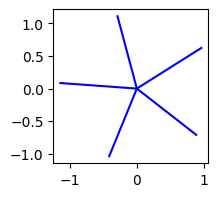

In [8]:
# Plot TMS representations.
en = copy.deepcopy(tms_model.W_in).detach().cpu().numpy().transpose()

plt.figure(figsize=(2,2))
for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

# Parallel TMS


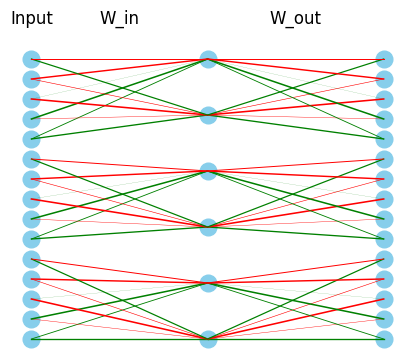

In [9]:
# Load TMS model
tms_model_p = tms.AutoencoderParallel(input_dim=5, hidden_dim=2, n_networks=3)
tms_model_p.load_state_dict(torch.load(f"{parent_dir}/models/tms_model_parallel.pth", weights_only=True))

DeleteParams(tms_model_p, [name for name, param in tms_model_p.named_parameters() if 'b' in name])

DrawNeuralNetwork(dict(tms_model_p.named_parameters()))

In [15]:
def model0(x):
    with torch.no_grad():
        return 0*x

n_networks = 3
n_features = 5

n_datapoints = 3*4096
X_tms_p, _, _= tms.GenerateTMSDataParallel(
    num_features=n_features, num_datapoints=n_datapoints,
    sparsity=.05,
    batch_size=16,
    n_networks=n_networks)

X_tms_p = X_tms_p.to(device)

hora_features = 15
hora_rank = 1
eigenmodel = EigenHora(tms_model_p, model0, loss.MSELoss, hora_features, hora_rank, device=device).to(device)
dataloader = TransformDataLoader(X_tms_p, batch_size=32, transform_fn=eigenmodel.compute_jacobian)
Train(eigenmodel, dataloader, lr=.01, n_epochs=20, L0_penalty=.1, device=device)

(12288, 15)
(12288,)
Epoch 0 : 1.384,  Reconstruction Loss: 1.246,  Sparsity Loss: 1.374
Epoch 1 : 0.882,  Reconstruction Loss: 0.731,  Sparsity Loss: 1.508
Epoch 2 : 0.804,  Reconstruction Loss: 0.654,  Sparsity Loss: 1.501
Epoch 3 : 0.796,  Reconstruction Loss: 0.647,  Sparsity Loss: 1.487
Epoch 4 : 0.790,  Reconstruction Loss: 0.643,  Sparsity Loss: 1.476
Epoch 5 : 0.789,  Reconstruction Loss: 0.641,  Sparsity Loss: 1.482
Epoch 6 : 0.788,  Reconstruction Loss: 0.640,  Sparsity Loss: 1.480
Epoch 7 : 0.779,  Reconstruction Loss: 0.628,  Sparsity Loss: 1.507
Epoch 8 : 0.726,  Reconstruction Loss: 0.571,  Sparsity Loss: 1.548
Epoch 9 : 0.697,  Reconstruction Loss: 0.542,  Sparsity Loss: 1.553
Epoch 10 : 0.697,  Reconstruction Loss: 0.542,  Sparsity Loss: 1.555
Epoch 11 : 0.696,  Reconstruction Loss: 0.541,  Sparsity Loss: 1.553
Epoch 12 : 0.697,  Reconstruction Loss: 0.542,  Sparsity Loss: 1.555
Epoch 13 : 0.701,  Reconstruction Loss: 0.545,  Sparsity Loss: 1.556
Epoch 14 : 0.694,  Reco

reconstructed network


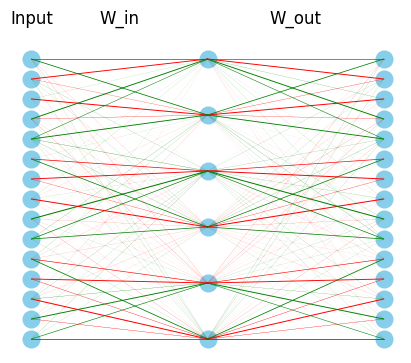

In [16]:
new_param_dict = {name:
    einops.einsum(eigenmodel.u_left[name], eigenmodel.u_right[name], 'h d ... f, w d ... f -> h w ...') for name in eigenmodel.u_right}
print('reconstructed network')
DrawNeuralNetwork(new_param_dict)



------feature 0----------


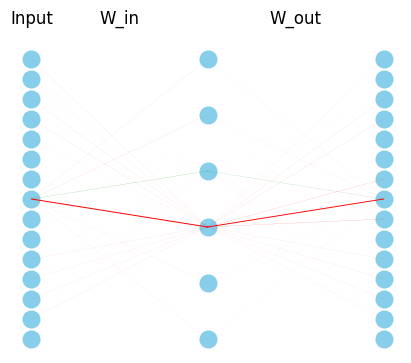

------feature 1----------


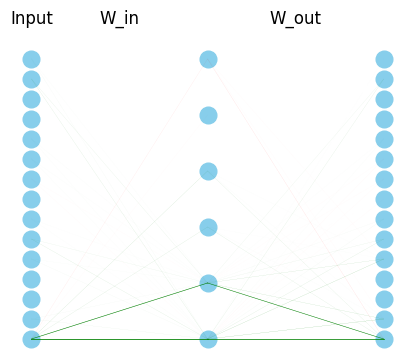

------feature 2----------


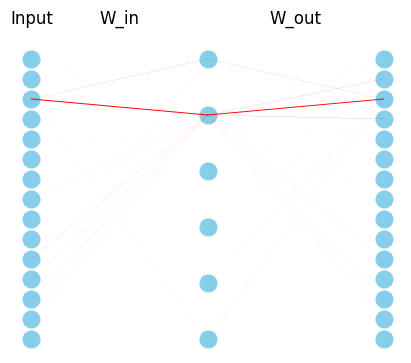

------feature 3----------


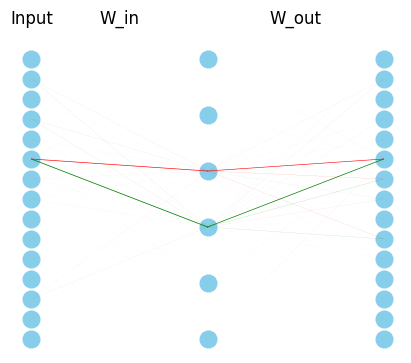

------feature 4----------


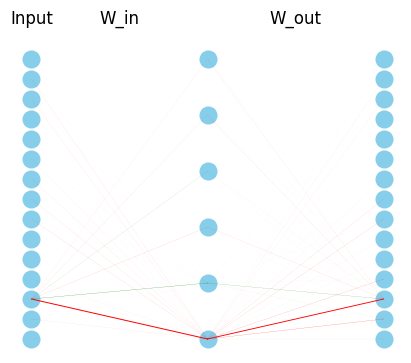

------feature 5----------


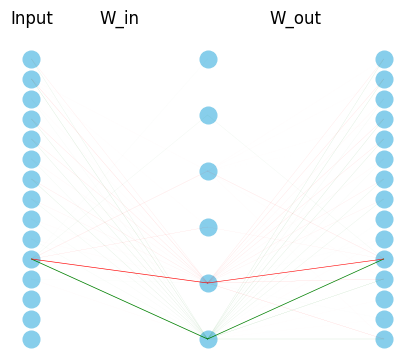

------feature 6----------


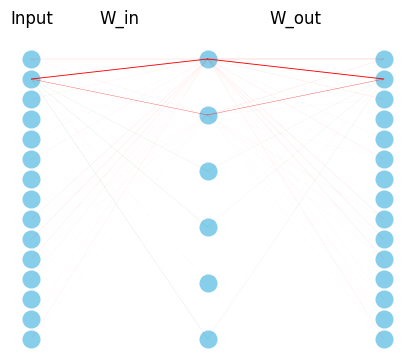

------feature 7----------


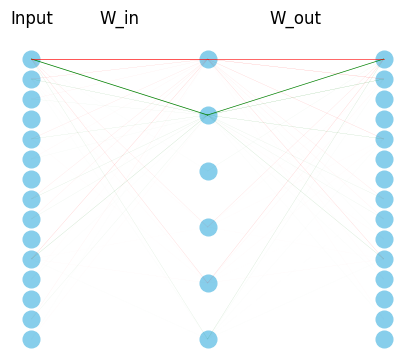

------feature 8----------


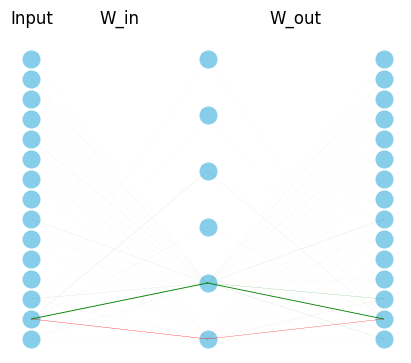

------feature 9----------


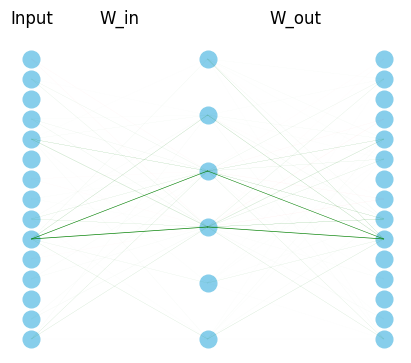

------feature 10----------


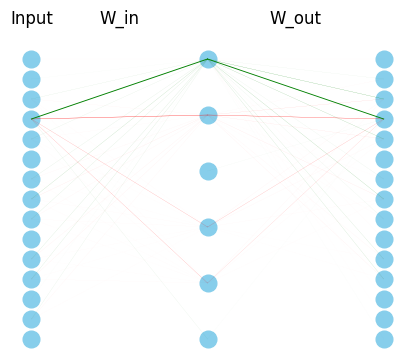

------feature 11----------


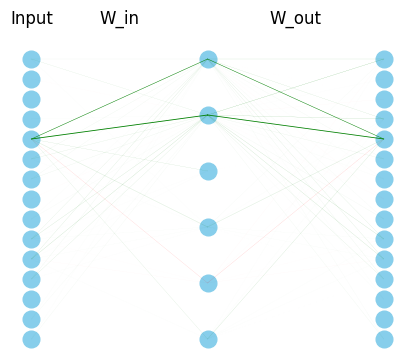

------feature 12----------


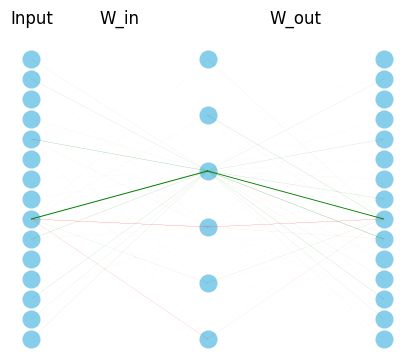

------feature 13----------


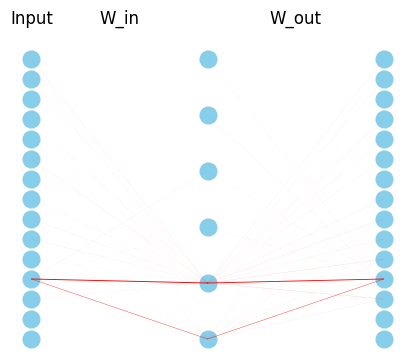

------feature 14----------


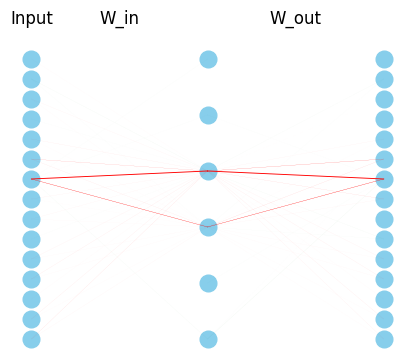

In [17]:
for i in range(hora_features):
    new_param_dict = {name:
        einops.einsum(eigenmodel.u_left[name][...,i], eigenmodel.u_right[name][...,i], 'h d ..., w d ... -> h w ...') for name in eigenmodel.u_right}
    print(f'------feature {i}----------')
    DrawNeuralNetwork(new_param_dict)



# Polytope



# Transformer






## Set up

In [53]:
# @title Import pretrained gpt2 (2 layers)
# Disable fused kernels (FlashAttention and memory-efficient attention)
# We have to disable this to compute second-order gradients on transformer models.
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2LMHeadModel
import transformer_lens
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)

# Ensure the math kernel is enabled (it is True by default)
torch.backends.cuda.enable_math_sdp(True)

# Load in a 2-L GPT2.
#gpt2 = GPT2Model.from_pretrained('gpt2', config=config)
#tokenizer = GPT2Tokenizer.from_pretrained("gpt2",)
#tokenizer.pad_token = tokenizer.eos_token
#transformer_model = TransformerWrapper(gpt2, tokenizer)


#gpt2  = transformer_lens.HookedTransformer.from_pretrained('gpt2-small')
#tokenizer = gpt2.tokenizer

#gpt2  = transformer_lens.HookedTransformer.from_pretrained("roneneldan/TinyStories-33M")#
#tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
#tokenizer.pad_token = tokenizer.eos_token
#transformer_model = TransformerWrapper(gpt2, tokenizer)


model_name = "EleutherAI/pythia-410m"

# Load tokenizer
tokenizer0 = AutoTokenizer.from_pretrained(model_name)
tokenizer0.pad_token = tokenizer0.eos_token

# Load model at checkpoint 1
model0 = AutoModelForCausalLM.from_pretrained(model_name, revision='step1')
model = AutoModelForCausalLM.from_pretrained(model_name)
transformer_model0 = TransformerWrapper(model0.to(device), tokenizer0, outputs_logits=False).requires_grad_(False).to(device)
transformer_model = TransformerWrapper(model.to(device), tokenizer0, outputs_logits=False).to(device)
print( [(name, param.numel()) for name, param in transformer_model.named_parameters()])
#transformer_model0  = transformer_lens.HookedTransformer.from_pretrained("roneneldan/TinyStories-2Layers-33M")#
#tokenizer0 = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
##tokenizer.pad_token = tokenizer.eos_token
#transformer_model0 = TransformerWrapper(transformer_model0, tokenizer0).requires_grad_(False)


# Make the eigenestimation a little smaller but only looking at a subset of the parameters.
# Pick a random subset of tensors to include in paramters, and turn the rest into frozen buffers.
params_to_delete = [name for name, param in transformer_model.named_parameters()]
params_to_delete = [p for p in params_to_delete if #('blocks.4.attn.W' not in p)]# and ('blocks.6.mlp.W' not in p)]#!='transformer.h.1.ln_2.weight']
   '12.attention.query_key_value.bias' not in p]#!='transformer.h.1.ln_2.weight']

# Delete 3/4 of the parameters.
#for p in (params_to_delete[::20]):
#  params_to_delete.remove(p)

DeleteParams(transformer_model, params_to_delete)

print(sum([p.numel() for p in transformer_model.parameters()]))
for n,p in transformer_model.named_parameters(): print(n, p.shape, p.numel())

# Load in data.
dataset = load_dataset('roneneldan/TinyStories', split="validation")
X_transformer = tokenize_and_concatenate(dataset, transformer_model.tokenizer, max_length = 24, add_bos_token=False)['tokens']
print(X_transformer.shape)

[('transformer.gpt_neox.embed_in.weight', 51511296), ('transformer.gpt_neox.layers.0.input_layernorm.weight', 1024), ('transformer.gpt_neox.layers.0.input_layernorm.bias', 1024), ('transformer.gpt_neox.layers.0.post_attention_layernorm.weight', 1024), ('transformer.gpt_neox.layers.0.post_attention_layernorm.bias', 1024), ('transformer.gpt_neox.layers.0.attention.query_key_value.weight', 3145728), ('transformer.gpt_neox.layers.0.attention.query_key_value.bias', 3072), ('transformer.gpt_neox.layers.0.attention.dense.weight', 1048576), ('transformer.gpt_neox.layers.0.attention.dense.bias', 1024), ('transformer.gpt_neox.layers.0.mlp.dense_h_to_4h.weight', 4194304), ('transformer.gpt_neox.layers.0.mlp.dense_h_to_4h.bias', 4096), ('transformer.gpt_neox.layers.0.mlp.dense_4h_to_h.weight', 4194304), ('transformer.gpt_neox.layers.0.mlp.dense_4h_to_h.bias', 1024), ('transformer.gpt_neox.layers.1.input_layernorm.weight', 1024), ('transformer.gpt_neox.layers.1.input_layernorm.bias', 1024), ('trans

## Eigenestimation

### Pull Gradients

In [65]:
import eigenestimation_algorithm.gradientextractor
importlib.reload(eigenestimation_algorithm.gradientextractor)

from eigenestimation_algorithm.gradientextractor import (
    JacobianExtractor,
    ExtractJacs,
)

param_dict = {name: param.detach().clone() for name, param in transformer_model.named_parameters()}

jac_extractor = JacobianExtractor(
        model=transformer_model.to(device),
        model0 = transformer_model0.to(device),
        loss = KLDivergenceLoss(),
        chunk_size=50, 
        param_dict = param_dict
)

torch.cuda.empty_cache()
gc.collect()

dataloader = DataLoader(X_transformer[::500,].to(device), batch_size=16, shuffle=False)
jacs, x = ExtractJacs(jac_extractor, dataloader)
torch.save(x, "../data/transformer/x.pt")
torch.save(jacs, "../data/transformer/jacs.pt")


Processing batch 1/25
Allocated memory: 7309.643264 MB
Cached memory: 23829.938176 MB
Processing batch 2/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 3/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 4/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 5/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 6/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 7/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 8/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 9/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 10/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 11/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 12/25
Allocated memory: 7309.643264

In [15]:
prompt = "How can I improve my research?"

input_ids = tokenizer0(prompt, return_tensors="pt").input_ids

gen_tokens = model0.generate(
    input_ids.to(device),
    do_sample=True,
    temperature=0.9,
    max_length=100,
)
gen_text = tokenizer0.batch_decode(gen_tokens)[-1]
gen_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'How can I improve my research?igraphy conceded ",ringer solutions exc SeverClickVERTGreen Carb Patriotsnest Carb confereren replicaOffsetreqュSouth medianrequentlyDEBUG dielectrichosClick exc]\\]Met formulate� analgesic parentheses silent stewoidesMEDdiscussion keen keen appellate airst 161 November Nich pert pe median curvature wells Him clutchClick wellsuba imbalance wellsentesinset germination opaqueruary ferry Fivericting metabolitesraintelig Richardsgger harassment Nich Arabidopsis对 Lance crunchvcfalsemucherent${对CAR Ré median эт WithinitatPaint canineruaryindex'

In [66]:
x = torch.load("../data/transformer/x.pt", weights_only=True)
jacs = torch.load("../data/transformer/jacs.pt", weights_only=True)


In [105]:
#@title Train Eigenmodel

torch.cuda.empty_cache()
gc.collect()

n_u_vectors = 50
batch_size = 32
lambda_penalty = [1,0]
n_epochs = 1000
learning_rate = .001
torch.manual_seed(42)
dataloader = DataLoader(TensorDataset(x.to(device), jacs.to(device)),
 batch_size=batch_size, shuffle=True)

eigenmodel_transformer = EigenEstimationComparison(
    transformer_model.to(device), transformer_model0, 
    KLDivergenceLoss(), n_u_vectors).to(device)

TrainEigenEstimationComparison(eigenmodel_transformer, dataloader, 
learning_rate, n_epochs, lambda_penalty, device='cuda')


RuntimeError: einsum(): subscript a has size 3072 for operand 1 which does not broadcast with previously seen size 90

In [73]:
def PrintActivatingExamplesTransformer(
    eigenmodel: torch.nn.Module,
    dataloader_X,
    feature_idx: int,
    top_k: int,
    batch_size: int = 32,  # Define a batch size for minibatch processing,
    device: str = 'cuda', 
    k_logits: int = 5
) -> None:
    
    # Split X into minibatches
    dH_list = []
    X = []
    bottom_logits_list = []
    top_logits_list = []
    with torch.no_grad():
        for x,jac in dataloader_X:
            H = einops.einsum(jac.to(device), eigenmodel.u[feature_idx], '... w, w -> ...')            
            dH_list.append(H)
            X.append(x)
    
    if True:#for f in feature_idx:

        # Concatenate dH results from all minibatches
        feature_vals = (torch.cat(dH_list, dim=0))
        X = (torch.cat(X, dim=0))

        #top_logits_idx = torch.cat(top_logits_list, dim=1)
        #bottom_logits_idx = torch.cat(bottom_logits_list, dim=1)

        # Flatten the tensor to find the top k values globally
        flattened_tensor = feature_vals.flatten()
        #print(top_logits_idx.shape)
        # Find the top 5 highest values and their indices in the flattened tensor
        top_values, top_idx = torch.topk((flattened_tensor), top_k, largest=True)
        # Convert the flattened indices back to the original 3D indices
        top_idx_sample, top_idx_token = torch.unravel_index(top_idx, feature_vals.shape)


        # Iterate over the top values and their indices
        for (sample, token, value) in zip(top_idx_sample, top_idx_token, top_values):
            #print(sample, token, value)
            # Decode the entire sequence of tokens for the current sample as individual tokens
            tokens_list = eigenmodel.model.tokenizer.convert_ids_to_tokens(X[sample].tolist())
            
            # Bold the token at the specific index
            tokens_list[token] = f"**{tokens_list[token]}**"
            
            # Join the tokens back together for displaying
            bolded_tokens = eigenmodel.model.tokenizer.convert_tokens_to_string(tokens_list[:(token+1)])
            bolded_tokens = bolded_tokens.replace("\n", "newline")

            # Decode the specific token with the highest value
            token_of_value = eigenmodel.model.tokenizer.decode(X[sample, token]).replace("\n", "newline")
            
            #top_logits =  [eigenmodel.model.tokenizer.decode(i) for i in (top_logits_idx[:,sample,token])]
            #bottom_logits =  [eigenmodel.model.tokenizer.decode(i) for i in (bottom_logits_idx[:,sample,token])]


            # Print the modified tokens with the bolded token and its value
            print(f"{bolded_tokens} -> {token_of_value} (Value: {value:.3f})")# top: {top_logits}, bottom: {bottom_logits}")

for i in range(50):
    print(f'---------{i}--------')
    PrintActivatingExamplesTransformer(
        eigenmodel_transformer,
        dataloader,
        i,
        5)

---------0--------
 He looked around and saw a duck.newlinenewlineâ€œHello,â€ said the rabbit. â**€** -> € (Value: 0.009)
 He looked around and saw a duck.newlinenewlineâ€œHello,â**€** -> € (Value: 0.007)
 story. She was very happy.Once upon a time, there lived a turtle named Trey.** T** ->  T (Value: 0.006)
 letting her take it** with** ->  with (Value: 0.006)
 day and build sand**cast** -> cast (Value: 0.005)
---------1--------
?â€newlinenewline**â** -> â (Value: 0.014)
 said, "I love you!"Ben saw a** beet** ->  beet (Value: 0.011)
 day and build sand**cast** -> cast (Value: 0.008)
 a time there was a boy, who was searching** high** ->  high (Value: 0.008)
 a time there was a boy, who was searching high** and** ->  and (Value: 0.008)
---------2--------
 the trunk and shouted to Mum, â€œ**M** -> M (Value: 0.006)
 Max were playing with their toy boats in the** bat** ->  bat (Value: 0.006)
 made Benny really curious! He wanted to touch it.newlinenewline**B** -> B (Value: 0.005)
 he woul

In [111]:
#@title Train Eigenmodel
n_u_vectors = 20
batch_size = 16
lambda_penalty = [1,.1]
n_epochs = 10
learning_rate = .001

torch.cuda.empty_cache()
gc.collect()

x_transformer_dataloader = DataLoader(X_transformer[:100,], batch_size=batch_size, shuffle=True)

torch.cuda.empty_cache()
gc.collect()

def custom_loss(outputs, truth):
    truth_rearranged = einops.rearrange(truth, '... p -> (...) p')
    outputs_rearranged = einops.rearrange(outputs, '... p -> (...) p')

    # Randomly select 3 indices based on probabilities in the last dimension
    selected_indices = torch.multinomial(truth_rearranged, num_samples=2, replacement=True)
    out = torch.gather(outputs_rearranged, 1, selected_indices) #nn.KLDivLoss(reduction='batchmean')(torch.log(torch.gather(truth_rearranged, 1, selected_indices)), torch.gather(outputs_rearranged, 1, selected_indices))
    return out

def M0(x):
    return (torch.ones_like(transformer_model(x))).softmax(dim=-1)

eigenmodel_transformer = EigenEstimationComparison(transformer_model, transformer_model,
                         custom_loss, n_u_vectors).to(device)

TrainEigenEstimationComparison(eigenmodel_transformer, x_transformer_dataloader, learning_rate, n_epochs, lambda_penalty, device='cuda', jac_chunk_size=50)


KeyboardInterrupt: 